In [ ]:
import os,sys,subprocess,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
pio.templates["mod"] = go.layout.Template(layout=dict(font=dict(family="Fira Code")))
pio.templates.default = "plotly_dark+mod"
from zipfile import ZipFile
from glob import glob
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,MinMaxScaler,RobustScaler,OneHotEncoder
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,train_test_split,StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,f1_score,precision_recall_curve
import miceforest as mf
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

2023-08-06 08:16:45.274046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
peng_lter = pd.read_csv('datasets/penguin/penguins_lter.csv')

In [ ]:
peng_lter.head(3)

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN


In [ ]:
peng_lter.shape

(344, 17)

In [ ]:
peng_lter.describe()

,Sample Number,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo)
count,344.000000,342.000000,342.000000,342.000000,342.000000,330.000000,331.000000
mean,63.151163,43.921930,17.151170,200.915205,4201.754386,8.733382,-25.686292
std,40.430199,5.459584,1.974793,14.061714,801.954536,0.551770,0.793961
min,1.000000,32.100000,13.100000,172.000000,2700.000000,7.632200,-27.018540
25%,29.000000,39.225000,15.600000,190.000000,3550.000000,8.299890,-26.320305
50%,58.000000,44.450000,17.300000,197.000000,4050.000000,8.652405,-25.833520
75%,95.250000,48.500000,18.700000,213.000000,4750.000000,9.172123,-25.062050
max,152.000000,59.600000,21.500000,231.000000,6300.000000,10.025440,-23.787670


In [ ]:
peng_lter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

As comments column is heavily downsized and missing we can omit it<br>
As this is heavily specie-related dataset lets clean the species column first<br>
since there is only one Region we can drop it<br>
since there is only one Stage we can drop it

In [ ]:
peng = peng_lter.drop(["Comments"],axis=1)
peng["Species"] = peng.Species.str.split(n=1,expand=True)[0]
peng.drop(columns=['Region'],inplace=True)
peng.drop(columns=['Stage'],inplace=True)
peng[['N','A']] = peng['Individual ID'].str.split(r'(\d+)',expand=True)[[1,3]]
peng['Date Egg'] = pd.to_datetime(peng['Date Egg'],format='mixed')
peng.drop(columns=['Individual ID'],inplace=True)
original_columns = peng.columns.to_list()
peng.columns = ['study','samples','species','island','clutch','date','culmenL','culmenD','flipperL','bmass','sex','delta_15n','delta_13c','N','A']
peng[['N','A']] = peng[['N','A']].astype(np.float32)

|Column Name|Description|Type|
|:----------|:----------|:---|
|StudyName|ID/Name of study that was carried out|categorical|
|SampleNumber|Sample of the study|categorical|
|Species|Species of penguin|categorical|
|Island|Island on which the study was conducted|categorical|
|Clutch Completion|$\cdots$|categorical|
|Date Egg|Date on which the study was conducted|continuous|
|Culmen Length|Length Upper ridge of the beak in mm|continuous|
|Flipper Length|Lenght of its flipper|continuous|
|Body Mass|Weight of the penguin|continuous|
|Sex|gender of the penguin|categorical|
|Delta 15 N|$\cdots$|continuous|
|Delta 13 C|$\cdots$|continuous|
|N|Individual Number assigned to penguin|categorical|
|A|Individual Number assigned to penguin|categorical|

In [ ]:
temp_df = peng.copy()

In [ ]:
ord_enc = OrdinalEncoder().set_output(transform='pandas')
temp_df[['study','species','island','clutch','sex']] = ord_enc.fit_transform(temp_df[['study','species','island','clutch','sex']])
temp_df.head()

,study,samples,species,island,clutch,date,culmenL,culmenD,flipperL,bmass,sex,delta_15n,delta_13c,N,A
0,0.0,1,0.0,2.0,1.0,2007-11-11,39.1,18.7,181.0,3750.0,2.0,NaN,NaN,1.0,1.0
1,0.0,2,0.0,2.0,1.0,2007-11-11,39.5,17.4,186.0,3800.0,1.0,8.94956,-24.69454,1.0,2.0
2,0.0,3,0.0,2.0,1.0,2007-11-16,40.3,18.0,195.0,3250.0,1.0,8.36821,-25.33302,2.0,1.0
3,0.0,4,0.0,2.0,1.0,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0
4,0.0,5,0.0,2.0,1.0,2007-11-16,36.7,19.3,193.0,3450.0,1.0,8.76651,-25.32426,3.0,1.0


In [ ]:
kds = mf.ImputationKernel(data=temp_df.drop(columns=['date']),datasets=5,random_state=1991)
kds.mice(10)

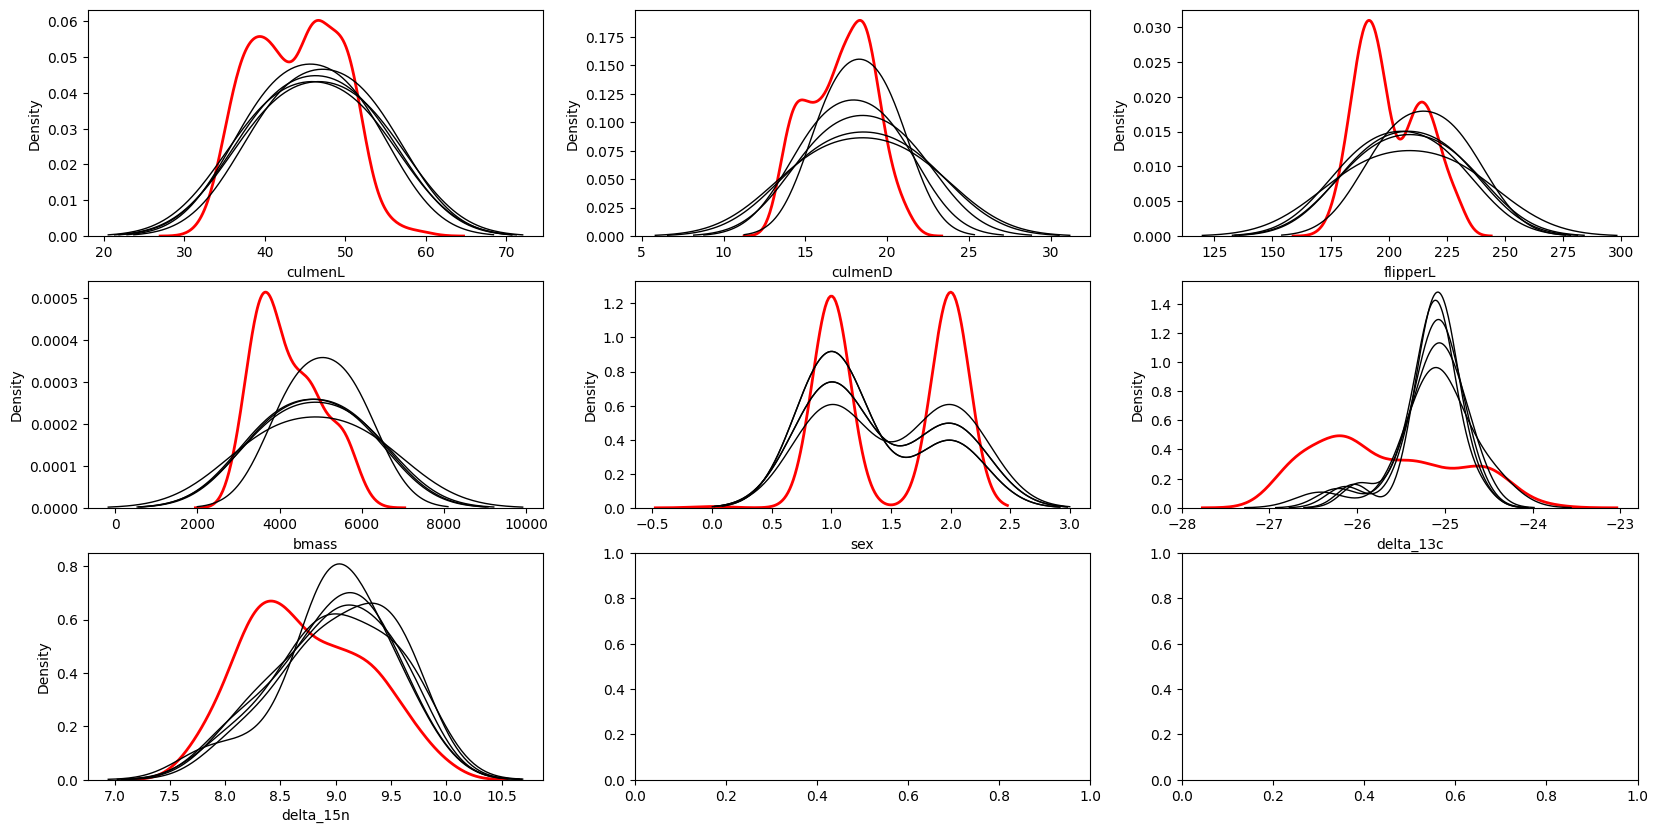

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
mf.ImputationKernel